# Quantum program creation
	

In this notebook, you will learn how to create a quantum program using Python with advanced elements:
- Part I: application of measures and resets, classical controls
- Part II: abstract gates
- Part III: quantum routines
- Part IV: export to AQASM and *.circ formats

These functionalities are provided by the Python ``qat.lang.AQASM`` module.

As ``qat.lang.AQASM`` module is a python extension of the AQASM language, this module contains all built-in quantum gates available in AQASM presented [here](available_gates.ipynb).

We recall the syntax to create a quantum program:

In [1]:
from qat.lang.AQASM import Program
prog = Program()

## Part I: Classical control, measures and resets

### Quantum and classical bit allocation

The allocation of quantum and classical bits is done via the ``qalloc`` and ``calloc`` methods, respectively. They return a register, which will then be used to refer to the qubits or classical bits.

In the following snippet, we allocated an 8-qubit register as well a classical register with 8 bits:

In [2]:
qbits = prog.qalloc(8)
cbits = prog.calloc(8)

### Measure
A measure is applied via the ``measure`` method. The result of the measure of a quantum bit is stored in a classical bit:

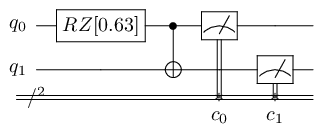

In [4]:
from qat.lang.AQASM import Program, RZ, CNOT
from math import pi

prog = Program()
qbits = prog.qalloc(2)
cbits = prog.calloc(2)
prog.apply(RZ(pi/5), qbits[0])
prog.apply(CNOT, qbits)
prog.measure(qbits, cbits)

circ = prog.to_circ()
%qatdisplay circ

### Classical control

Here, we apply a Hadamard gate on second qubit classically controlled by second bit (it requires the classical bit to be initialized):
![figure](../../img/CCH.png)

In [6]:
from qat.lang.AQASM import Program, H

prog = Program()
cbits = prog.calloc(5)
qbits = prog.qalloc(5)
# Initializing cbits[2]
prog.measure(qbits[4], cbits[2])
# Apply Hadamard only if cbits[2] is set
prog.cc_apply(cbits[2], H, qbits[2])

### Qubit reset

The following snippet shows how to reset a qubit.

In [7]:
from qat.lang.AQASM import Program 

prog = Program()
qbits = prog.qalloc(8)


# Reseting qubits 1, 3 and 4.
prog.reset([qbits[1], qbits[3:5]])
print(prog.op_list[0].qbits)

[<qat.lang.AQASM.bits.Qbit object at 0x7fa9e6fb6fa0>, <qat.lang.AQASM.bits.Qbit object at 0x7fa9e6fb6ac0>, <qat.lang.AQASM.bits.Qbit object at 0x7fa9e6fb6af0>]


### Cbit reset

The reset method also allows to reset a classical bit.

In [8]:
from qat.lang.AQASM import Program 

prog = Program()
qbits = prog.qalloc(8)
cbits = prog.calloc(8)

# Reseting qubits 1, 3 and 4, and cbit 0.
prog.reset([qbits[1], qbits[3:5]], [cbits[0]])
# Reseting only cbit 1
prog.reset([], [cbits[1]])
print(prog.op_list[0].qbits)
print(prog.op_list[0].cbits)
print(prog.op_list[1].qbits)
print(prog.op_list[1].cbits)

[<qat.lang.AQASM.bits.Qbit object at 0x7fa9e6fa46d0>, <qat.lang.AQASM.bits.Qbit object at 0x7fa9e6fa4790>, <qat.lang.AQASM.bits.Qbit object at 0x7fa9e6fa4250>]
[]


### Logic operations on classical bits


Here, we set the classical bit of index 0 through a logic operation on classical bits 1 and 2 (which have themselves been initialized through measurement).

The second argument of the logic method is a boolean formula built using operators '&', '|', '^', '~' and cbits.

In [9]:
from qat.lang.AQASM import Program

prog = Program()
qbits = prog.qalloc(2)
cbits = prog.calloc(8)
prog.measure(qbits, cbits[1:3])
prog.logic(cbits[0], cbits[1] & cbits[2])

## Part II: Abstract gates
Besides constant gates, such as Hadamard, or CNOT, pyAQASM offers the possibilty to manipulate and declare parametrized gates, called abstract gates.
pyAQASM natively supports 4 abstract gates (e.g RX, RY, RZ, PH). New abstract gates can be defined (see below).

Any gate can be modified using the following gate operators:
- *dag()*: Creates  the dagger of the parent Gate
- *ctrl()*: Creates a controlled version of the parent Gate
- *conj()*: Creates the complex conjugate of the parent Gate
- *trans()*: Creates the transpose of the parent Gate.

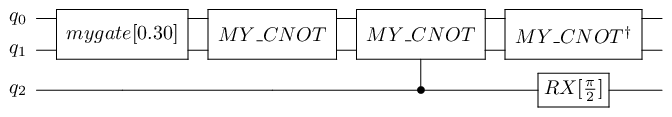

In [12]:
from qat.lang.AQASM import Program, RX, Y, AbstractGate
import numpy as np

prog = Program()
q = prog.qalloc(3)

# Abstract gates do not require a particular matrix description: they are boxes with a name and a
# signature:
my_gate = AbstractGate("mygate", # The name of the gate
                       [float], # Its signature: (here a single float)
                       arity=2) # Its arity 
prog.apply(my_gate(0.3), q[0], q[1])

## A constant abstract gate (a CNOT)
# The matrices lines and columns should be enumerated using the first qubit as
# most significant (q)bit
# For instance, the matrix corresponding to a CNOT gate whose first argument is the control qubit
# will look like:
# | 1 0 0 0 |
# | 0 1 0 0 |
# | 0 0 0 1 |
# | 0 0 1 0 |
My_CNOT = AbstractGate("MY\_CNOT", [], arity=2,
                       matrix_generator=lambda : np.array([[1,0,0,0],
                                                           [0,1,0,0],
                                                           [0,0,0,1],
                                                           [0,0,1,0]]))

prog.apply(My_CNOT(), q[0], q[1])

# To extend: More generaly a control-U gate will have shape
# | I 0 |
# | 0 U |
# and the first qubit passed as argument will be the control qubit

# Abstract gates, once instantiated, can be controlled:

prog.apply(My_CNOT().ctrl(), q[2], q[1], q[0])

# Or inversed:
prog.apply(My_CNOT().dag(), q[0], q[1])

# Use an AbstractGate
prog.apply(RX(np.pi/2.), q[2])

circ = prog.to_circ()

%qatdisplay circ

## Part III: Quantum Routines


The ``QRoutine`` object allows for the convenient creation of sub programs (akin to a re-useable sequence of gates) within a quantum program:

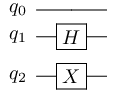

In [15]:
from qat.lang.AQASM import Program, QRoutine, X, H

# Creates a quantum routine consisting of a H gate on the first qubit, and a X gate on the second qubit
subprog = QRoutine()
subprog.apply(H, 0)
subprog.apply(X, 1)

# Now, create a program and apply the quantum routine to the qubit register
prog = Program()
qbits = prog.qalloc(3)
prog.apply(subprog, qbits[1:3])

circ = prog.to_circ()
%qatdisplay circ

``QRoutine``'s behave similarly to quantum gates. As a consequence, one can compose them:

In [14]:
subprog2 = QRoutine()
subprog2.apply(X, 0)
subprog2.apply(subprog, 0, 1)

prog2 = Program()
qbits = prog2.qalloc(3)
prog2.apply(subprog2, qbits[0:2])

circ2 = prog2.to_circ()
%qatdisplay circ2

NameError: name 'QRoutine' is not defined

One can also apply the gate operators (ctrl, conj, dag etc.) to quantum routines, e.g:

In [ ]:
conjsub = subprog.conj()
prog.apply(conjsub, qbits[0:2])

## Part IV: Export to AQASM and *.circ files

### Atos Quantum Assembly Language (AQASM)

The AQASM language is a quantum assembly language. The ``export`` method of the ``Program`` class allows to export a quantum program to the corresponding AQASM file:

In [ ]:
from qat.lang.AQASM import Program, Y, CNOT

prog = Program()
qbits = prog.qalloc(2)
cbits = prog.calloc(2)
prog.apply(Y, qbits[0])
prog.apply(CNOT, qbits)
prog.measure(qbits, cbits)
prog.export("test.aqasm")
!cat test.aqasm

### *.circ files

Quantum circuits can be dumped to a binary file format with extension ``* .circ``. Such a file is suitable for direct simulation using a quantum processor using the QLM's command-line tools.


In [ ]:
circ.dump("test.circ")

!ls test.*